In [1]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms

from glob import glob
import PIL
from PIL import Image
import json
from collections import Counter
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
trainroot = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/'
valroot ='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/'

def load_root(root):
    files = glob(root + '*')
    json_path = ''
    for f in files:
        if os.path.isfile(f):
            ext = os.path.splitext(f)[1]
            if ext == '.json':
                json_path = f
    
        if json_path != '':
            break
            
    with open(json_path, "r") as f:
        data = json.load(f)
    
    return data['images'], data['annotations']

train_imgs, train_segs = load_root(trainroot)
val_imgs, val_segs = load_root(valroot)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def indexed_ground_truth(images, annotations, index, root):
    pilimg = Image.open(root + images[index]['file_name'])
    fig, ax = plt.subplots(1)
    ax.imshow(pilimg)
    
    x, y, w, h = annotations[index]['bbox']
    rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

In [5]:
class Configure(torch.utils.data.Dataset):
    def __init__(self, imgs, segs, root):
        self.imgs = imgs
        self.segs = segs
        self.root = root

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]['file_name']
        seg = self.segs[idx]['bbox']

        x, y, w, h = map(int, seg)
        
        pilimg = Image.open(self.root + image)
        mask = np.zeros((640, 640), dtype = np.uint8)
        mask[y : y + h, x : x + w] = 1
        mask = torch.from_numpy(mask).long()

        img_tensor = transforms.ToTensor()(pilimg)
        return img_tensor, mask

In [6]:
trainset = Configure(imgs = train_imgs, segs = train_segs, root = trainroot)
valset = Configure(imgs = val_imgs, segs = val_segs, root = valroot)

In [7]:
batch_size = 4
num_workers = 0

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, num_workers = num_workers)
testloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = num_workers)

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = (3, 3), padding = "same")
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = (3, 3), padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.rel = nn.ReLU()
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        return self.rel(x)

In [9]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding = "same")
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.bn1(self.up(x))
        x = self.bn2(self.conv(x))
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, encoder_blocks = 4, multiplicity = 64, pool_stride = 2):
        super(UNet, self).__init__()
        self.initial_conv = DoubleConv(in_channels, multiplicity)
        self.encoder_blocks = encoder_blocks
        self.multiplicity = multiplicity
        self.pool_stride = pool_stride
        
        self.maxpool = nn.MaxPool2d(2, stride = pool_stride)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.res = nn.ModuleList()
        self.final_conv = nn.Conv2d(multiplicity, 2, kernel_size = 1)

        skip_channels = [multiplicity]
        kernels = multiplicity
        for _ in range(self.encoder_blocks):
            self.downs.append(DoubleConv(kernels, kernels * 2))
            kernels *= 2
            skip_channels.append(kernels)

        for i in range(self.encoder_blocks):
            self.ups.append(UpConv(kernels, kernels // 2))
            self.res.append(DoubleConv(kernels // 2 + skip_channels[-(i + 2)], kernels // 2))
            kernels //= 2

    def forward(self, x):
        residuals = []
        x = self.initial_conv(x)
        residuals.append(x)

        for i, conv in enumerate(self.downs):
            x = self.maxpool(x) 
            x = conv(x)
            residuals.append(x)

        for up, res_block, skip in zip(self.ups, self.res, reversed(residuals[:-1])):
            x = up(x)
            x = torch.cat([skip, x], dim = 1)
            x = res_block(x)

        x = self.final_conv(x)
        return x

In [11]:
unet = UNet().to(device)
print(unet)

UNet(
  (initial_conv): DoubleConv(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rel): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downs): ModuleList(
    (0): DoubleConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel): ReLU()
    )
    (1): DoubleConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(unet.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = 255)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 5, verbose = True)

In [13]:
num_epochs = 100

for epoch in range(num_epochs):
    unet.train()
    print(f"\n ↪ Epoch {epoch + 1}/{num_epochs}")
    train_loss = 0

    loop = tqdm(trainloader, desc = f"[Training]", leave = True)
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = unet(images)              
        loss = criterion(outputs, masks)     
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        loop.set_postfix(loss = loss.item())

    train_loss /= len(trainloader)

    unet.eval()
    val_loss = 0
    with torch.no_grad():
        loop = tqdm(testloader, desc = f"[Validation]", leave = False)
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)
            outputs = unet(images)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            loop.set_postfix(loss = loss.item())

    val_loss /= len(testloader)
    scheduler.step(val_loss)
    print('[log] Epoch: %d \tValidation Loss: %d \tTraining Loss: %.6f' %(epoch, val_loss, train_loss))


 ↪ Epoch 1/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 0 	Validation Loss: 0 	Training Loss: 0.144701

 ↪ Epoch 2/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 1 	Validation Loss: 0 	Training Loss: 0.121197

 ↪ Epoch 3/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 2 	Validation Loss: 0 	Training Loss: 0.115118

 ↪ Epoch 4/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 3 	Validation Loss: 0 	Training Loss: 0.110730

 ↪ Epoch 5/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 4 	Validation Loss: 0 	Training Loss: 0.107426

 ↪ Epoch 6/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 5 	Validation Loss: 0 	Training Loss: 0.104356

 ↪ Epoch 7/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 6 	Validation Loss: 0 	Training Loss: 0.100195

 ↪ Epoch 8/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 7 	Validation Loss: 0 	Training Loss: 0.097905

 ↪ Epoch 9/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 8 	Validation Loss: 0 	Training Loss: 0.094671

 ↪ Epoch 10/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 9 	Validation Loss: 0 	Training Loss: 0.089868

 ↪ Epoch 11/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 10 	Validation Loss: 0 	Training Loss: 0.087798

 ↪ Epoch 12/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 11 	Validation Loss: 0 	Training Loss: 0.086377

 ↪ Epoch 13/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 12 	Validation Loss: 0 	Training Loss: 0.085183

 ↪ Epoch 14/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 13 	Validation Loss: 0 	Training Loss: 0.083685

 ↪ Epoch 15/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 14 	Validation Loss: 0 	Training Loss: 0.082414

 ↪ Epoch 16/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 15 	Validation Loss: 0 	Training Loss: 0.081088

 ↪ Epoch 17/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 16 	Validation Loss: 0 	Training Loss: 0.078804

 ↪ Epoch 18/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 17 	Validation Loss: 0 	Training Loss: 0.077037

 ↪ Epoch 19/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 18 	Validation Loss: 0 	Training Loss: 0.075629

 ↪ Epoch 20/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 19 	Validation Loss: 0 	Training Loss: 0.074233

 ↪ Epoch 21/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 20 	Validation Loss: 0 	Training Loss: 0.072925

 ↪ Epoch 22/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 21 	Validation Loss: 0 	Training Loss: 0.071422

 ↪ Epoch 23/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 22 	Validation Loss: 0 	Training Loss: 0.069907

 ↪ Epoch 24/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 23 	Validation Loss: 0 	Training Loss: 0.068339

 ↪ Epoch 25/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 24 	Validation Loss: 0 	Training Loss: 0.066809

 ↪ Epoch 26/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 25 	Validation Loss: 0 	Training Loss: 0.065044

 ↪ Epoch 27/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 26 	Validation Loss: 0 	Training Loss: 0.063355

 ↪ Epoch 28/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 27 	Validation Loss: 0 	Training Loss: 0.061527

 ↪ Epoch 29/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 28 	Validation Loss: 0 	Training Loss: 0.059406

 ↪ Epoch 30/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 29 	Validation Loss: 0 	Training Loss: 0.057830

 ↪ Epoch 31/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 30 	Validation Loss: 0 	Training Loss: 0.056960

 ↪ Epoch 32/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 31 	Validation Loss: 0 	Training Loss: 0.054478

 ↪ Epoch 33/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 32 	Validation Loss: 0 	Training Loss: 0.052113

 ↪ Epoch 34/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 33 	Validation Loss: 0 	Training Loss: 0.049934

 ↪ Epoch 35/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 34 	Validation Loss: 0 	Training Loss: 0.047643

 ↪ Epoch 36/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 35 	Validation Loss: 0 	Training Loss: 0.045828

 ↪ Epoch 37/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 36 	Validation Loss: 0 	Training Loss: 0.046958

 ↪ Epoch 38/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 37 	Validation Loss: 0 	Training Loss: 0.046210

 ↪ Epoch 39/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 38 	Validation Loss: 0 	Training Loss: 0.044757

 ↪ Epoch 40/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 39 	Validation Loss: 0 	Training Loss: 0.043094

 ↪ Epoch 41/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 40 	Validation Loss: 0 	Training Loss: 0.041596

 ↪ Epoch 42/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 41 	Validation Loss: 0 	Training Loss: 0.040251

 ↪ Epoch 43/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 42 	Validation Loss: 0 	Training Loss: 0.043311

 ↪ Epoch 44/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 43 	Validation Loss: 0 	Training Loss: 0.043279

 ↪ Epoch 45/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 44 	Validation Loss: 0 	Training Loss: 0.042753

 ↪ Epoch 46/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 45 	Validation Loss: 0 	Training Loss: 0.041827

 ↪ Epoch 47/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 46 	Validation Loss: 0 	Training Loss: 0.040810

 ↪ Epoch 48/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 47 	Validation Loss: 0 	Training Loss: 0.039758

 ↪ Epoch 49/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 48 	Validation Loss: 0 	Training Loss: 0.042827

 ↪ Epoch 50/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 49 	Validation Loss: 0 	Training Loss: 0.043065

 ↪ Epoch 51/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 50 	Validation Loss: 0 	Training Loss: 0.043455

 ↪ Epoch 52/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 51 	Validation Loss: 0 	Training Loss: 0.043753

 ↪ Epoch 53/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 52 	Validation Loss: 0 	Training Loss: 0.043909

 ↪ Epoch 54/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 53 	Validation Loss: 0 	Training Loss: 0.044079

 ↪ Epoch 55/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 54 	Validation Loss: 0 	Training Loss: 0.051062

 ↪ Epoch 56/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 55 	Validation Loss: 0 	Training Loss: 0.051187

 ↪ Epoch 57/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 56 	Validation Loss: 0 	Training Loss: 0.050535

 ↪ Epoch 58/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 57 	Validation Loss: 0 	Training Loss: 0.050007

 ↪ Epoch 59/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 58 	Validation Loss: 0 	Training Loss: 0.049487

 ↪ Epoch 60/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 59 	Validation Loss: 0 	Training Loss: 0.049009

 ↪ Epoch 61/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 60 	Validation Loss: 0 	Training Loss: 0.051572

 ↪ Epoch 62/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 61 	Validation Loss: 0 	Training Loss: 0.049461

 ↪ Epoch 63/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 62 	Validation Loss: 0 	Training Loss: 0.048926

 ↪ Epoch 64/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 63 	Validation Loss: 0 	Training Loss: 0.048552

 ↪ Epoch 65/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 64 	Validation Loss: 0 	Training Loss: 0.048210

 ↪ Epoch 66/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 65 	Validation Loss: 0 	Training Loss: 0.047900

 ↪ Epoch 67/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 66 	Validation Loss: 0 	Training Loss: 0.048549

 ↪ Epoch 68/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 67 	Validation Loss: 0 	Training Loss: 0.047955

 ↪ Epoch 69/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 68 	Validation Loss: 0 	Training Loss: 0.047663

 ↪ Epoch 70/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 69 	Validation Loss: 0 	Training Loss: 0.047458

 ↪ Epoch 71/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 70 	Validation Loss: 0 	Training Loss: 0.047287

 ↪ Epoch 72/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 71 	Validation Loss: 0 	Training Loss: 0.047128

 ↪ Epoch 73/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 72 	Validation Loss: 0 	Training Loss: 0.047346

 ↪ Epoch 74/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 73 	Validation Loss: 0 	Training Loss: 0.047109

 ↪ Epoch 75/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 74 	Validation Loss: 0 	Training Loss: 0.046969

 ↪ Epoch 76/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 75 	Validation Loss: 0 	Training Loss: 0.046859

 ↪ Epoch 77/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 76 	Validation Loss: 0 	Training Loss: 0.046766

 ↪ Epoch 78/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 77 	Validation Loss: 0 	Training Loss: 0.046681

 ↪ Epoch 79/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 78 	Validation Loss: 0 	Training Loss: 0.046699

 ↪ Epoch 80/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 79 	Validation Loss: 0 	Training Loss: 0.046528

 ↪ Epoch 81/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 80 	Validation Loss: 0 	Training Loss: 0.046455

 ↪ Epoch 82/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 81 	Validation Loss: 0 	Training Loss: 0.046402

 ↪ Epoch 83/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 82 	Validation Loss: 0 	Training Loss: 0.046353

 ↪ Epoch 84/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 83 	Validation Loss: 0 	Training Loss: 0.046308

 ↪ Epoch 85/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 84 	Validation Loss: 0 	Training Loss: 0.046249

 ↪ Epoch 86/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 85 	Validation Loss: 0 	Training Loss: 0.046185

 ↪ Epoch 87/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 86 	Validation Loss: 0 	Training Loss: 0.046148

 ↪ Epoch 88/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 87 	Validation Loss: 0 	Training Loss: 0.046120

 ↪ Epoch 89/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 88 	Validation Loss: 0 	Training Loss: 0.046095

 ↪ Epoch 90/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 89 	Validation Loss: 0 	Training Loss: 0.046072

 ↪ Epoch 91/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 90 	Validation Loss: 0 	Training Loss: 0.046015

 ↪ Epoch 92/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 91 	Validation Loss: 0 	Training Loss: 0.045995

 ↪ Epoch 93/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 92 	Validation Loss: 0 	Training Loss: 0.045980

 ↪ Epoch 94/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 93 	Validation Loss: 0 	Training Loss: 0.045966

 ↪ Epoch 95/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 94 	Validation Loss: 0 	Training Loss: 0.045954

 ↪ Epoch 96/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 95 	Validation Loss: 0 	Training Loss: 0.045942

 ↪ Epoch 97/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 96 	Validation Loss: 0 	Training Loss: 0.045905

 ↪ Epoch 98/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 97 	Validation Loss: 0 	Training Loss: 0.045898

 ↪ Epoch 99/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 98 	Validation Loss: 0 	Training Loss: 0.045891

 ↪ Epoch 100/100


[Training]:   0%|          | 0/376 [00:00<?, ?it/s]

[Validation]:   0%|          | 0/108 [00:00<?, ?it/s]

[log] Epoch: 99 	Validation Loss: 0 	Training Loss: 0.045885


In [14]:
testroot = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/'
test_imgs, test_segs = load_root(testroot)
testset = Configure(imgs = test_imgs, segs = test_segs, root = testroot)
valloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, num_workers = num_workers)

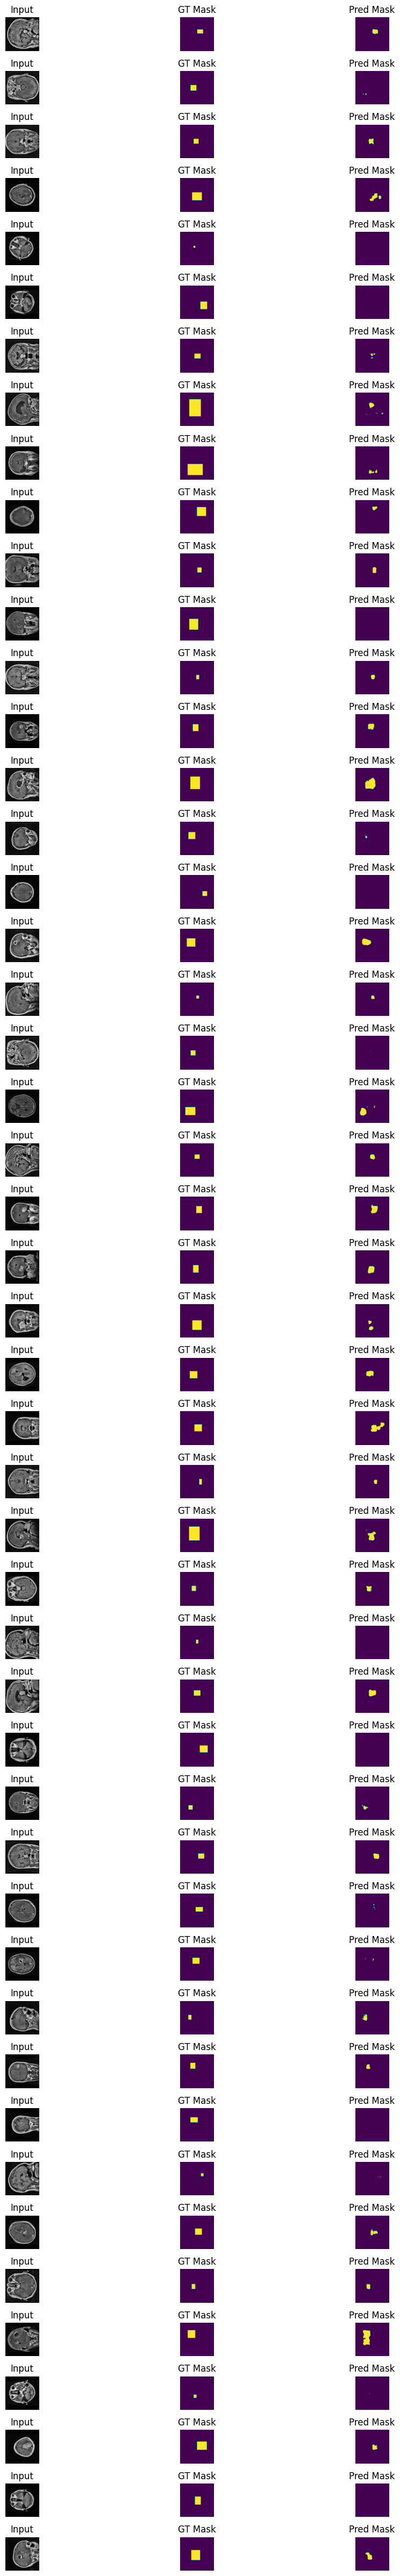

In [15]:
unet.eval()

num_batches = 12  
batch_size = 4    

with torch.no_grad():
    plt.figure(figsize = (12, num_batches * 4))  

    img_index = 0
    for b, (images, masks) in enumerate(valloader):
        if b >= num_batches:
            break

        images = images.to(device)
        masks = masks.to(device)
        outputs = unet(images)
        preds = torch.argmax(outputs, dim = 1)

        for i in range(batch_size):
            plt.subplot(num_batches * batch_size, 3, img_index * 3 + 1)
            img_np = images[i].cpu().permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)
            plt.imshow(img_np)
            plt.title("Input")
            plt.axis("off")

            plt.subplot(num_batches * batch_size, 3, img_index * 3 + 2)
            plt.imshow(masks[i].cpu().numpy())
            plt.title("GT Mask")
            plt.axis("off")

            plt.subplot(num_batches * batch_size, 3, img_index * 3 + 3)
            plt.imshow(preds[i].cpu().numpy())
            plt.title("Pred Mask")
            plt.axis("off")

            img_index += 1

    plt.tight_layout()
    plt.show()
